In [1]:
#importamos librerías
import sys
from scipy import stats
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics


In [2]:
#cargamos los datos
black_data = pd.read_csv("BlackFriday.csv")
black_data.head()

,User_ID,Product_ID,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase
0,1000001,P00069042,F,0-17,10,A,2,0,3,NaN,NaN,8370
1,1000001,P00248942,F,0-17,10,A,2,0,1,6.0,14.0,15200
2,1000001,P00087842,F,0-17,10,A,2,0,12,NaN,NaN,1422
3,1000001,P00085442,F,0-17,10,A,2,0,12,14.0,NaN,1057
4,1000002,P00285442,M,55+,16,C,4+,0,8,NaN,NaN,7969


In [3]:
#visualizamos las variables numéricas de los datos
black_data.describe()
#verificamos los tipos de valor en cada celda
black_data.dtypes

User_ID                         int64
Product_ID                     object
Gender                         object
Age                            object
Occupation                      int64
City_Category                  object
Stay_In_Current_City_Years     object
Marital_Status                  int64
Product_Category_1              int64
Product_Category_2            float64
Product_Category_3            float64
Purchase                        int64
dtype: object

In [4]:
cat_values = ["Gender", "Age", "Occupation", "City_Category", "Marital_Status", "Product_Category_1", 
              "Product_Category_2", "Product_Category_3"]
for column in cat_values:
    black_data[column] = black_data[column].astype('category')
black_data.dtypes

User_ID                          int64
Product_ID                      object
Gender                        category
Age                           category
Occupation                    category
City_Category                 category
Stay_In_Current_City_Years      object
Marital_Status                category
Product_Category_1            category
Product_Category_2            category
Product_Category_3            category
Purchase                         int64
dtype: object

In [5]:
#Suma de valores pérdidos en cada columna. Pandas reconoce tanto una celda vacía como el valor NA como NaN
#https://towardsdatascience.com/data-cleaning-with-python-and-pandas-detecting-missing-values-3e9c6ebcf78b
black_data.isnull().sum()

User_ID                            0
Product_ID                         0
Gender                             0
Age                                0
Occupation                         0
City_Category                      0
Stay_In_Current_City_Years         0
Marital_Status                     0
Product_Category_1                 0
Product_Category_2            166986
Product_Category_3            373299
Purchase                           0
dtype: int64

In [6]:
#verificamos si hay valores pérdidos con otras sintaxis
#lista con valores NA comunes
missing_values = ["n/a", "na", "--", "Na"]
black_data = pd.read_csv("BlackFriday.csv", na_values= missing_values)
black_data.isnull().sum()

User_ID                            0
Product_ID                         0
Gender                             0
Age                                0
Occupation                         0
City_Category                      0
Stay_In_Current_City_Years         0
Marital_Status                     0
Product_Category_1                 0
Product_Category_2            166986
Product_Category_3            373299
Purchase                           0
dtype: int64

In [7]:
#verificamos la correlación entre variables para verificar si las variables con valores pérdidos tienen alguna 
#correlación alta con otra variables
black_data.corr()

,User_ID,Occupation,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase
User_ID,1.000000,-0.023024,0.018732,0.003687,0.001471,0.004045,0.005389
Occupation,-0.023024,1.000000,0.024691,-0.008114,-0.000031,0.013452,0.021104
Marital_Status,0.018732,0.024691,1.000000,0.020546,0.015116,0.019452,0.000129
Product_Category_1,0.003687,-0.008114,0.020546,1.000000,0.540423,0.229490,-0.314125
Product_Category_2,0.001471,-0.000031,0.015116,0.540423,1.000000,0.543544,-0.209973
Product_Category_3,0.004045,0.013452,0.019452,0.229490,0.543544,1.000000,-0.022257
Purchase,0.005389,0.021104,0.000129,-0.314125,-0.209973,-0.022257,1.000000


In [8]:
#verificamos el nro de filas que tienen valores pérdidos en las 2 variables
len(black_data[black_data['Product_Category_2'].isnull() & black_data['Product_Category_2'].isnull()])


166986

<BarContainer object of 18 artists>

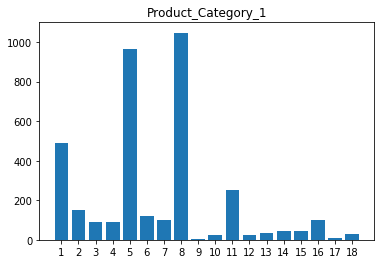

In [9]:
#verificamos la distribución de Product_Category_1 para comparar con los valores pérdidos de Product_Category_2 y
#Product_Category_3
prod_1 = black_data['Product_ID'].groupby(black_data['Product_Category_1']).nunique()
prod_2 = black_data['Product_ID'].groupby(black_data['Product_Category_2']).nunique()
prod_3 = black_data['Product_ID'].groupby(black_data['Product_Category_2']).nunique()
prod_1

bins = np.sort(black_data['Product_Category_1'].unique())
plt.xticks(bins)
plt.title('Product_Category_1')
plt.bar(bins, prod_1)

In [10]:
prod_2
prod_3

Product_Category_2
2.0     127
3.0      12
4.0     146
5.0     128
6.0      60
7.0       4
8.0     353
9.0      20
10.0     14
11.0     70
12.0     45
13.0     51
14.0    317
15.0    138
16.0    221
17.0     76
18.0     18
Name: Product_ID, dtype: int64

In [11]:
#sustituimos los valores pérdidos de Product_category_2 y Product_Categori_3 por 0
bf_data = black_data.fillna(0)
bf_data.isnull().sum()

User_ID                       0
Product_ID                    0
Gender                        0
Age                           0
Occupation                    0
City_Category                 0
Stay_In_Current_City_Years    0
Marital_Status                0
Product_Category_1            0
Product_Category_2            0
Product_Category_3            0
Purchase                      0
dtype: int64

Text(0,0.5,'Purchase ($)')

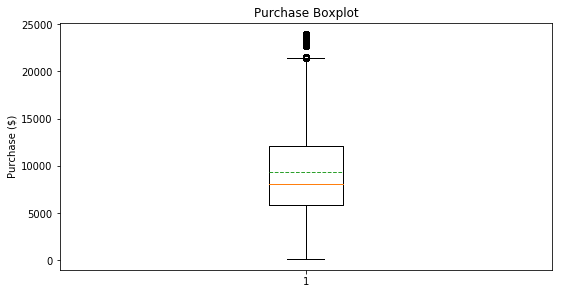

In [12]:
#Representamos el gráfico de cajas de la variable "Purchase" y vemos que existen valores extremos 
plt.figure(figsize=[30,10])
plt.subplot(231)
cajas = plt.boxplot(x=bf_data['Purchase'], showmeans = True, meanline = True)
plt.title('Purchase Boxplot')
plt.ylabel('Purchase ($)')

In [13]:
# Almacenamos los valores extremos en una lista
outliers = list(cajas["fliers"][0].get_data()[1])

# Comprobamos la longitud para ver cuántos registros se consideran extremos.
print "Num. extremos", len(outliers)
print "Num. total", len(bf_data)

# Borramos los datos extremos
bf_data = bf_data[~bf_data.Purchase.isin(outliers)]

# Comparamos las longitudes antes y después
print "Num. sin extremos", len(bf_data)

Num. extremos 2665
Num. total 537577
Num. sin extremos 534912


In [14]:
# (solo informativo)

# Número de valores diferentes por campo
print('Número de valores distintos: \n')
for i in bf_data.columns:
    print i, ':',bf_data[i].nunique()
    
# Tipo de datos de cada campo
print('\nTipo de datos: \n')
print (bf_data.info())

# Matriz de covarianzas 
print('\nMatriz de covarianzas: \n')
bf_data.cov()

Número de valores distintos: 

User_ID : 5891
Product_ID : 3623
Gender : 2
Age : 7
Occupation : 21
City_Category : 3
Stay_In_Current_City_Years : 5
Marital_Status : 2
Product_Category_1 : 18
Product_Category_2 : 18
Product_Category_3 : 16
Purchase : 16928

Tipo de datos: 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 534912 entries, 0 to 537576
Data columns (total 12 columns):
User_ID                       534912 non-null int64
Product_ID                    534912 non-null object
Gender                        534912 non-null object
Age                           534912 non-null object
Occupation                    534912 non-null int64
City_Category                 534912 non-null object
Stay_In_Current_City_Years    534912 non-null object
Marital_Status                534912 non-null int64
Product_Category_1            534912 non-null int64
Product_Category_2            534912 non-null float64
Product_Category_3            534912 non-null float64
Purchase                      5349

,User_ID,Occupation,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase
User_ID,2.938243e+06,-259.157409,15.673851,22.231876,34.977127,44.180688,3.995448e+04
Occupation,-2.591574e+02,42.551512,0.078639,-0.212696,0.268939,0.488749,6.621299e+02
Marital_Status,1.567385e+01,0.078639,0.241651,0.037164,0.002677,-0.013706,-2.118050e+00
Product_Category_1,2.223188e+01,-0.212696,0.037164,13.981018,-1.081807,-9.175687,-6.262855e+03
Product_Category_2,3.497713e+01,0.268939,0.002677,-1.081807,38.481980,3.506119,8.125750e+02
Product_Category_3,4.418069e+01,0.488749,-0.013706,-9.175687,3.506119,39.227552,8.913526e+03
Purchase,3.995448e+04,662.129868,-2.118050,-6262.854928,812.574982,8913.525816,2.396630e+07


# Análisis de datos

## Selección de los grupos de datos que se quieren analizar/comparar (planificación de los análisis a aplicar)

In [15]:
for column in cat_values:
    bf_data[column] = bf_data[column].astype('category')
bf_data.dtypes

User_ID                          int64
Product_ID                      object
Gender                        category
Age                           category
Occupation                    category
City_Category                 category
Stay_In_Current_City_Years      object
Marital_Status                category
Product_Category_1            category
Product_Category_2            category
Product_Category_3            category
Purchase                         int64
dtype: object

In [16]:
#análisis estadístico descriptivo
bf_data.describe()

,User_ID,Purchase
count,5.349120e+05,534912.000000
mean,1.002991e+06,9264.683312
std,1.714130e+03,4895.538823
min,1.000001e+06,185.000000
25%,1.001495e+06,5857.000000
50%,1.003031e+06,8052.000000
75%,1.004416e+06,12037.000000
max,1.006040e+06,21382.000000


Observamos que la única variable continua es Purchase. Al utilizar el comando describe observamos también User_ID, pero en este caso al ser la identificación del usuario no tiene sentido los resultados que se indican de las medidas estadísticas de tendencia central y de dispersión.

## Comprobación de la normalidad y homogeneidad de la varianza 

(array([ 31460.,  49075.,  84686., 133527.,  63712.,  53719.,  12516.,
         64897.,  14053.,  27267.]),
 array([  185. ,  2304.7,  4424.4,  6544.1,  8663.8, 10783.5, 12903.2,
        15022.9, 17142.6, 19262.3, 21382. ]),
 <a list of 10 Patch objects>)

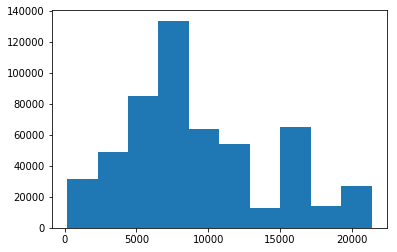

In [17]:
#visualizamos la distribución de la variable Purchase
plt.hist(bf_data['Purchase'])

In [18]:
#Aplicamos el test shapiro sobre una muestra porque en la primera prueba obtenemos una advertencia de que el resultado 
#de p-value no es preciso para muestras mayores a 5000
stats.shapiro(bf_data['Purchase'].sample(n=5000, random_state=1))

(0.948160707950592, 8.500486679363989e-39)

In [19]:
#Analizamos la normalidad de la variable Purchase sobre las muestras de hombres y mujeres
purch_female = stats.shapiro(bf_data['Purchase'][bf_data['Gender']=='F'].sample(n=4000, random_state =1))
purch_male = stats.shapiro(bf_data['Purchase'][bf_data['Gender']=='M'].sample(n=4000, random_state =1))
if purch_female[1]<0.05:
    print ("la variable no es normal")
else:
    print ("la variable es normal")

la variable no es normal


In [20]:
#Analizamos la normalidad de la variable Purchase sobre las muestras de las variables Gender, Age, 
#City_category y Marital_Status

bf_data['Marital_Status'] = bf_data['Marital_Status'].astype('string')
data_select = ['Gender', 'Age', 'City_Category', 'Marital_Status']
for value in data_select:
    var = bf_data[value].unique()
    for i in range(len(var)):
        shap_num = stats.shapiro(bf_data['Purchase'][bf_data[value]==var[i]].sample(n=4000, random_state =1))
        shap_dict = {value +  var[i]: shap_num[1]}
        print shap_dict
        

{'GenderF': 2.5066778487601058e-36}
{'GenderM': 4.8127757814600645e-35}
{'Age0-17': 5.139896688634084e-35}
{'Age55+': 9.008948526672442e-35}
{'Age26-35': 5.026331586775207e-37}
{'Age46-50': 1.0039744573860795e-34}
{'Age51-55': 5.787979785021028e-35}
{'Age36-45': 1.2200622319021308e-34}
{'Age18-25': 1.8001336817500195e-34}
{'City_CategoryA': 6.918803054624665e-36}
{'City_CategoryC': 2.0746218293659712e-35}
{'City_CategoryB': 1.3683688669744834e-34}
{'Marital_Status0': 7.594307656192534e-36}
{'Marital_Status1': 1.2874526113096774e-34}


In [21]:
#Probamos la homosteceidad 
for value in data_select:
    var = bf_data[value].unique()
    for i in range(len(var)):
        flig_num = stats.fligner(bf_data['Purchase'], bf_data['Purchase'][bf_data[value]==var[i]])
        if flig_num[1] <0.05:
            flig_stat = u"presentan varianzas diferentes"
        elif flig_num[1] >= 0.05:
            flig_stat = u"presentan varianzas similares"
        flig_dict = {value +  var[i] + " & Purchase": flig_stat.encode('utf8')}
        print flig_dict
        

{'GenderF & Purchase': 'presentan varianzas diferentes'}
{'GenderM & Purchase': 'presentan varianzas diferentes'}
{'Age0-17 & Purchase': 'presentan varianzas diferentes'}
{'Age55+ & Purchase': 'presentan varianzas diferentes'}
{'Age26-35 & Purchase': 'presentan varianzas similares'}
{'Age46-50 & Purchase': 'presentan varianzas diferentes'}
{'Age51-55 & Purchase': 'presentan varianzas similares'}
{'Age36-45 & Purchase': 'presentan varianzas similares'}
{'Age18-25 & Purchase': 'presentan varianzas diferentes'}
{'City_CategoryA & Purchase': 'presentan varianzas diferentes'}
{'City_CategoryC & Purchase': 'presentan varianzas diferentes'}
{'City_CategoryB & Purchase': 'presentan varianzas diferentes'}
{'Marital_Status0 & Purchase': 'presentan varianzas similares'}
{'Marital_Status1 & Purchase': 'presentan varianzas diferentes'}


In [22]:
# Estudio de la dependencia de variables categóricas: Test Chi Cuadrado 
user_att = ['Gender', 'Age', 'City_Category', 'Marital_Status', 'Occupation', 'City_Category' ]
p_cat = ['Product_Category_1', 'Product_Category_2', 'Product_Category_3']

# Nuestra hipótesis nula será que no existe relación entre la categoría de producto
# y cada una de las variables en data_select.
for i in user_att:
    for j in p_cat:
        tabla_cont = pd.crosstab(bf_data[i], bf_data[j])
        chi2, p, dof, ex = stats.chi2_contingency(tabla_cont, correction=True, lambda_=None)
        if p <0.05:
            print i, ' es independiente de ', j
        else:
            print i, ' puede que sea independiente de Product_Category_1, estudiar más a fondo ', j

Gender  es independiente de  Product_Category_1
Gender  es independiente de  Product_Category_2
Gender  es independiente de  Product_Category_3
Age  es independiente de  Product_Category_1
Age  es independiente de  Product_Category_2
Age  es independiente de  Product_Category_3
City_Category  es independiente de  Product_Category_1
City_Category  es independiente de  Product_Category_2
City_Category  es independiente de  Product_Category_3
Marital_Status  es independiente de  Product_Category_1
Marital_Status  es independiente de  Product_Category_2
Marital_Status  es independiente de  Product_Category_3
Occupation  es independiente de  Product_Category_1
Occupation  es independiente de  Product_Category_2
Occupation  es independiente de  Product_Category_3
City_Category  es independiente de  Product_Category_1
City_Category  es independiente de  Product_Category_2
City_Category  es independiente de  Product_Category_3


In [23]:
#removemos las variables relacionadas con Product category
bf_select = bf_data.drop(['Product_Category_2', 'Product_Category_3'], axis =1)


In [24]:
X = bf_select.drop(['Purchase'], axis=1).sample(n=50000, random_state =1)
Y = bf_select['Purchase'].sample(n=50000, random_state =1)
X.head()

,User_ID,Product_ID,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1
357216,1001068,P00302742,F,18-25,4,B,2,0,8
389881,1006001,P00354642,F,26-35,7,A,0,1,8
34323,1005302,P00230842,F,0-17,10,A,1,0,8
46172,1001121,P00347242,M,55+,7,C,4+,1,8
379025,1004309,P00042842,M,26-35,0,C,3,0,5


In [25]:
level_var = ['Gender', 'Age', 'City_Category', 'Stay_In_Current_City_Years']
#transformamos las variables categóricas en 0s y 1s
for feature in level_var:
    X.loc[:,feature] = LabelEncoder().fit_transform(X[feature])

X.head()

,User_ID,Product_ID,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1
357216,1001068,P00302742,0,1,4,1,2,0,8
389881,1006001,P00354642,0,2,7,0,0,1,8
34323,1005302,P00230842,0,0,10,0,1,0,8
46172,1001121,P00347242,1,6,7,2,4,1,8
379025,1004309,P00042842,1,2,0,2,3,0,5


In [26]:
#separamos las variables con más de 2 categorías

X = pd.DataFrame(OneHotEncoder().fit(X[level_var]).transform(X[level_var]).toarray(), index=X.index, 
                               columns=OneHotEncoder().fit(X[level_var]).get_feature_names(level_var))
X = pd.DataFrame(StandardScaler().fit_transform(X), columns=X.columns, index=X.index)
X.head()

C:\Users\bfigueroa\AppData\Local\Continuum\anaconda2\lib\site-packages\sklearn\preprocessing\_encoders.py:368: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


,Gender_0.0,Gender_1.0,Age_0.0,Age_1.0,Age_2.0,Age_3.0,Age_4.0,Age_5.0,Age_6.0,City_Category_0.0,City_Category_1.0,City_Category_2.0,Stay_In_Current_City_Years_0.0,Stay_In_Current_City_Years_1.0,Stay_In_Current_City_Years_2.0,Stay_In_Current_City_Years_3.0,Stay_In_Current_City_Years_4.0
357216,1.754130,-1.754130,-0.168662,2.115054,-0.808863,-0.504309,-0.299071,-0.275152,-0.201183,-0.603814,1.170904,-0.671941,-0.395361,-0.737642,2.095293,-0.455805,-0.428126
389881,1.754130,-1.754130,-0.168662,-0.472801,1.236303,-0.504309,-0.299071,-0.275152,-0.201183,1.656139,-0.854041,-0.671941,2.529337,-0.737642,-0.477260,-0.455805,-0.428126
34323,1.754130,-1.754130,5.929021,-0.472801,-0.808863,-0.504309,-0.299071,-0.275152,-0.201183,1.656139,-0.854041,-0.671941,-0.395361,1.355672,-0.477260,-0.455805,-0.428126
46172,-0.570083,0.570083,-0.168662,-0.472801,-0.808863,-0.504309,-0.299071,-0.275152,4.970608,-0.603814,-0.854041,1.488225,-0.395361,-0.737642,-0.477260,-0.455805,2.335761
379025,-0.570083,0.570083,-0.168662,-0.472801,1.236303,-0.504309,-0.299071,-0.275152,-0.201183,-0.603814,-0.854041,1.488225,-0.395361,-0.737642,-0.477260,2.193918,-0.428126


In [27]:
#separamos el dataset en train y test
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)

#Aplicamos Random Forest como modelo de clasificación
clf=RandomForestClassifier(n_estimators=10)

clf.fit(X_train,Y_train)

y_pred=clf.predict(X_test)

In [28]:
metrics.accuracy_score(Y_test, y_pred)

0.0001

In [29]:
# CLUSTERING K-Means
# Buscamos agrupaciones de datos midiendo la distancia entre las observaciones.
# Las variables categóricas las transformaremos en paramétricas para poder medir distancias entre ellas
# Para ello utilizaremos el método de One-Hot-Encoder 

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# Tomamos una muestra más reducida para probar los datos
bf_sample = bf_data.sample(n=3000, random_state =1)

# Vamos a intentar agrupar los clientes por las compras que hayan hecho por categoría 1
# Primero nos quedamos solo con los atributos propios del usuario y nos quedamos con 
# una línea por user_id.
bf_clus = bf_sample.drop(['Product_ID', 'Product_Category_1', 'Product_Category_2', 
                      'Product_Category_3', 'Purchase'], axis=1).groupby('User_ID')

bf_clus = bf_clus.agg(lambda x: x.value_counts().index[-1])

# Creamos columnas concatenando atributo-valor y rellenamos con 1 en las características que cumple y 0 en el resto

columnas = list(bf_clus.columns.values)
# Codificamos los posibles valores de cada columna
for col in columnas:
    bf_clus.loc[:,col] = LabelEncoder().fit_transform(bf_clus[col])
#Definimos el codificador
encoder = OneHotEncoder().fit(bf_clus[columnas])
# Añadimos las columnas concatenadas
bf_clus = pd.concat([bf_clus, pd.DataFrame(encoder.transform(bf_clus[columnas]).toarray(), 
                                       index=bf_clus.index, columns=encoder.get_feature_names(columnas))], axis=1)
# Eliminamos las anteriores
bf_clus.drop(columnas, axis=1, inplace=True)

bf_clus.head(5)


,Gender_0.0,Gender_1.0,Age_0.0,Age_1.0,Occupation_0.0,Occupation_1.0,City_Category_0.0,City_Category_1.0,Stay_In_Current_City_Years_0.0,Stay_In_Current_City_Years_1.0,Stay_In_Current_City_Years_2.0,Stay_In_Current_City_Years_3.0,Stay_In_Current_City_Years_4.0,Marital_Status_0.0,Marital_Status_1.0
User_ID,,,,,,,,,,,,,,,
1000002,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
1000003,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
1000006,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
1000008,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
1000011,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0


In [30]:
# Creamos columnas para cada categoría 1 y agregamos las ventas
cat_1 = pd.pivot_table(
        bf_sample[['User_ID', 'Product_Category_1', 'Purchase']],
        values='Purchase',
        index='User_ID',
        columns='Product_Category_1',
        aggfunc=np.sum
    ).fillna(0) 
bf_clus = bf_clus.join(cat_1)

# Unificamos la escala de los datos
bf_clus_es = StandardScaler().fit_transform(bf_clus)

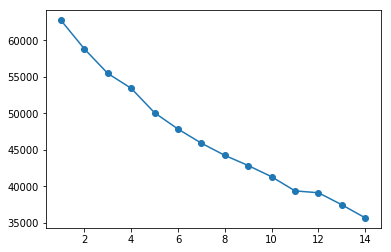

In [47]:
# Seleccionamos el número de clústeres que queremos crear por el método del codo

distancias = []
K = range(1,15)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(bf_clus_es)
    distancias.append(km.inertia_)
    modelos.append(km)
plt.plot(K, distancias, 'o-')
plt.show()

In [51]:
# Como es dificil encontrar el codo en la gráfica,
# vemos qué valores toma la silueta para distintos k
from sklearn.metrics import silhouette_score

K = range(1,14)

for k in K:
    km = modelos[k]
    a = silhouette_score(bf_clus_es, km.predict(bf_clus_es))
    print "Silhouette con k = ", k, "es", a
 

Silhouette con k =  1 es 0.08763633276706283
Silhouette con k =  2 es 0.10227103351667262
Silhouette con k =  3 es 0.09293382539471015
Silhouette con k =  4 es 0.12379656948300985
Silhouette con k =  5 es 0.1469091919567352
Silhouette con k =  6 es 0.1259901973432352
Silhouette con k =  7 es 0.11880828611336589
Silhouette con k =  8 es 0.12237184719820292
Silhouette con k =  9 es 0.13181037547466343
Silhouette con k =  10 es 0.12061062932882632
Silhouette con k =  11 es 0.12339955388876776
Silhouette con k =  12 es 0.12267210352491288
Silhouette con k =  13 es 0.15509770811438967
